# Outcome Span Extraction

In [1]:
import pandas as pd
import ast

def read_csv_with_lists(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Iterate over each column
    for column in df.columns:
        # Check if the column contains strings that represent lists
        if df[column].dtype == object:
            try:
                # Convert the strings to lists using ast.literal_eval
                df[column] = df[column].apply(ast.literal_eval)
            except (ValueError, SyntaxError):
                # Skip the column if it cannot be converted to a list
                pass
    
    return df

In [22]:
gold_df = read_csv_with_lists('data/outcome_extraction_testing.csv')
print(gold_df.value_counts('new_case_outcome', normalize = True))
gold_df.head()

new_case_outcome
No relief            0.639881
Relief               0.349702
Conditional Order    0.010417
dtype: float64


,raw_file_text,raw_file_name,full_cleaned,metadata,content,case_citation,file_number,language,year,ltb_location,decision_date,hearing_date,url,adjudicating_member,new_case_outcome
0,Metadata:\nDate:\t2017-01-18\nFile number:\t\n...,CEL-62600-16.txt,"[Metadata:, Date: 2017-01-18, File number:, CE...","[Date: 2017-01-18, File number:, CEL-62600-16,...",[Arrears Worksheet File Number: CEL-62600-16 T...,"CEL-62600-16 (Re), 2017 CanLII 9545 (ON LTB)",CEL-62600-16,English,2016,Mississauga,01/18/2017,01/30/2017,https://canlii.ca/t/gxq6n,Avril Cardoso,No relief
1,Metadata:\nDate:\t2017-01-09\nFile number:\t\n...,CEL-62852-16.txt,"[Metadata:, Date: 2017-01-09, File number:, CE...","[Date: 2017-01-09, File number:, CEL-62852-16,...",[Arrears Worksheet File Number: CEL-62852-16 T...,"CEL-62852-16 (Re), 2017 CanLII 9535 (ON LTB)",CEL-62852-16,English,2016,Mississauga,01/09/2017,01/09/2017,https://canlii.ca/t/gxq6r,Tiisetso Russell,Relief
2,Metadata:\nDate:\t2017-01-09\nFile number:\t\n...,CEL-63024-16.txt,"[Metadata:, Date: 2017-01-09, File number:, CE...","[Date: 2017-01-09, File number:, CEL-63024-16,...",[Arrears Worksheet File Number: CEL-63024-16 T...,"CEL-63024-16 (Re), 2017 CanLII 9543 (ON LTB)",CEL-63024-16,English,2016,Mississauga,01/09/2017,01/09/2017,https://canlii.ca/t/gxq6s,Tiisetso Russell,Relief
3,Metadata:\nDate:\t2017-01-20\nFile number:\t\n...,CEL-63056-16.txt,"[Metadata:, Date: 2017-01-20, File number:, CE...","[Date: 2017-01-20, File number:, CEL-63056-16,...",[Arrears Worksheet File Number: CEL-63056-16 T...,"CEL-63056-16 (Re), 2017 CanLII 9537 (ON LTB)",CEL-63056-16,English,2016,Mississauga,01/09/2017,01/09/2017,https://canlii.ca/t/gxq6t,Tiisetso Russell,No relief
4,Metadata:\nDate:\t2017-02-03\nFile number:\t\n...,CEL-63193-16.txt,"[Metadata:, Date: 2017-02-03, File number:, CE...","[Date: 2017-02-03, File number:, CEL-63193-16,...",[Arrears Worksheet File Number: CEL-63193-16 T...,"CEL-63193-16 (Re), 2017 CanLII 30828 (ON LTB)",CEL-63193-16,English,2016,Mississauga,01/10/2017,02/03/2017,https://canlii.ca/t/h3w7b,Karen Wallace,No relief


In [95]:
import re
import itertools

def find_all_positions(text: str, keyword: str):
    """
    Finds all positions of a keyword in a given text.

    This function searches for a keyword in a given text and returns a list of positions where the keyword is found.

    Parameters
    ----------
    text : str
        The text to search within.
    keyword : str
        The keyword to find in the text.

    Returns
    -------
    list
        A list of integers representing the positions of the keyword in the text.

    Examples
    --------
    >>> find_all_positions("This is an example sentence.", "example")
    [11]
    """
    positions = []
    start = 0
    while True:
        index = text.find(keyword, start)
        if index == -1:
            break
        positions.append(index)
        start = index + 1
    return positions

def get_outcome_span(text: str, return_truncated: bool = True):
    """
    Extracts the outcome span from a given text using different methods.

    This function extracts the outcome span from a given text using multiple methods. It first attempts to find
    the span between occurrences of the phrases "accordance with" and "ordered". If that method fails, it then
    tries to find the span after the phrase "it is ordered". If that also fails, it looks for the span after the
    phrase "find". The function returns the extracted outcome span as a cleaned string.

    Parameters
    ----------
    text : str
        The text from which to extract the outcome span.

    Returns
    -------
    str or None
        The extracted outcome span as a cleaned string, or None if no span is found.

    Examples
    --------
    >>> get_outcome_span(unstructured_case_file)
    "In accordance with the order, it is ordered that the defendant pays a fine."
    """

    ############### FIRST METHOD ################

    for keyword in ['in accordance with', 'grant', 'relief', 'fair']: # these all seem common but none seem to exist in 100% of cases

        if keyword in text:

            # find all occurrences of 'in accordance with' and 'ordered'
            accordance_with_indices = [m.end() for m in re.finditer(keyword, text)]
            ordered_indices = [m.start() for m in re.finditer("ordered", text)]

            # generate all possible pairs of indices
            index_pairs = list(itertools.product(accordance_with_indices, ordered_indices))

            # filter pairs where 'accordance with' index is less than 'ordered' index
            index_pairs = [(i, j) for (i, j) in index_pairs if i < j]
            if index_pairs:
                # find the pair with the shortest distance between indices
                min_distance_pair = min(index_pairs, key = lambda x: x[1] - x[0])
                try:
                    best_subset = text[min_distance_pair[0] - 300 : min_distance_pair[1] + 400].strip()
                except IndexError:
                    best_subset = text[min_distance_pair[0] - 300 : min_distance_pair[1]].strip()

                best_subset = best_subset.split(". ")

                if best_subset:

                    sent_id = [idx for idx, i in enumerate(best_subset) if keyword in i.lower()][0]

                    clean_outcome = best_subset[sent_id]

                    # return None
                    # print("METHOD 1")

                    # return JUST the (presumably) most relevant outcome span (after cleaning it up a bit)
                    if return_truncated:
                        clean_outcome = re.sub(r'\[\d+\]', '', clean_outcome)
                        clean_outcome = re.sub(r'^\d+\.\s*', '', clean_outcome).strip() # removes numbers from the start of the string such as "16. " from start of string

                        if ")" in clean_outcome[:10] and "(" not in clean_outcome[:10]:
                            clean_outcome = clean_outcome.split(")")[1].strip()
                        return clean_outcome

                    # return all case file text until the end of the outcome span
                    else:
                        return text[: text.find(clean_outcome) + len(clean_outcome)]

                else:
                    continue

    ################ SECOND METHOD ################

    keyword = "it is ordered"
    if keyword in text.lower():
        matches = find_all_positions(text.lower(), keyword)

        for match in matches:
            try: # match + 400 chars
                clean_outcome = ". ".join(text[match - 200 : match + 400].split(". ")[1:-1]) 
            except IndexError: # match idx until end of string (+ 400 is sometimes out of range)
                clean_outcome = ". ".join(text[match - 400 :].split(". ")[1:-1])

            # return None
            # print("METHOD 2")

            if return_truncated:
                clean_outcome = re.sub(r'\[\d+\]', '', clean_outcome)
                clean_outcome = re.sub(r'^\d+\.\s*', '', clean_outcome).strip() # removes numbers from the start of the string such as "16. " from start of string

                if ")" in clean_outcome[:10] and "(" not in clean_outcome[:10]:
                    clean_outcome = clean_outcome.split(")")[1].strip()
                return clean_outcome

            # return all case file text until the end of the outcome span
            else:
                return text[: text.find(clean_outcome) + len(clean_outcome)]
            
            # if this somehow returns nothing, continue to the next match in the "it is ordered" matches
            continue

    ############### THIRD METHOD ################

    keyword = " find " # spaces to prevent "finding" or other derivations from being included -- specifically looking for statements like "I find that..."
    if keyword in text.lower():
        matches = find_all_positions(text.lower(), keyword)
        for match in matches:

            try: # match + 400 chars
                clean_outcome = ". ".join(text[match - 200 : match + 400].split(". ")[1:-1]) 
            except IndexError: # match idx until end of string (+ 400 is sometimes out of range)
                clean_outcome = ". ".join(text[match - 400 :].split(". ")[1:-1])

            # return None

            # if the outcome doesn't end with a period, add one. it looks nicer :)
            # print("METHOD 3")
            
            if return_truncated:
                clean_outcome = re.sub(r'\[\d+\]', '', clean_outcome)
                clean_outcome = re.sub(r'^\d+\.\s*', '', clean_outcome).strip() # removes numbers from the start of the string such as "16. " from start of string

                if ")" in clean_outcome[:10] and "(" not in clean_outcome[:10]:
                    clean_outcome = clean_outcome.split(")")[1].strip()
                return clean_outcome

            # if this somehow returns nothing, continue to the next match in the " find " matches
            continue

    # if absolutely nothing works, return none and try Longformer or something idk
    return None

test_row = 456
# for test_row in range(20, 40):
test_str = " ".join(gold_df.loc[test_row, 'content'])
print(gold_df.loc[test_row, 'url'])
print(gold_df.loc[test_row, 'new_case_outcome'])
cospan = get_outcome_span(test_str, return_truncated = True)
if cospan:
    print(len(cospan.split()))
    print(cospan)
print("ROW", test_row)
print()

https://canlii.ca/t/hwbk0
Relief
44
I have considered all of the disclosed circumstances in accordance with subsection 83(2) of the Residential Tenancies Act, 2006 (the 'Act'), and find that it would not be unfair to postpone the eviction until August 23, 2018, pursuant to subsection 83(1)(b) of the Act
ROW 456



28515


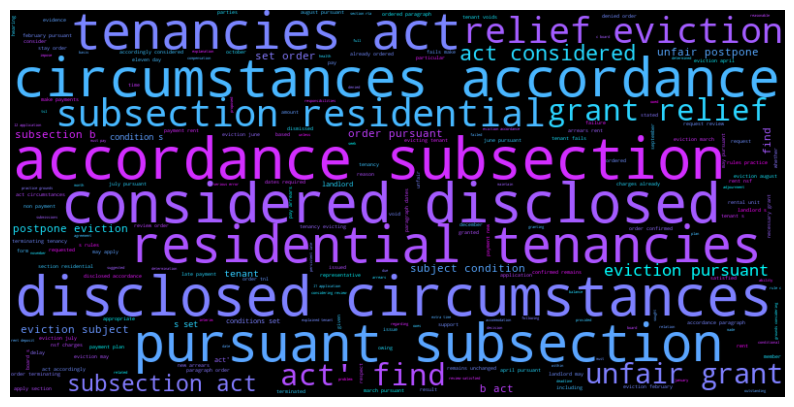

In [41]:
all_outcomes = []
for test_row in gold_df.index:
    test_str = " ".join(gold_df.loc[test_row, 'content'])
    # print(gold_df.loc[test_row, 'url'])
    # print(gold_df.loc[test_row, 'new_case_outcome'])
    cospan = get_outcome_span(test_str, return_truncated = True)
    if cospan:
        all_outcomes.extend([word.lower().strip() for word in cospan.lower().split()]) # list of words

print(len(all_outcomes))
all_outcomes[:500]

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
filtered_words = [word.lower().strip() for word in all_outcomes if word.lower().strip() not in stop_words]
# filtered_words = list(set([word.lower().strip() for word in all_outcomes if word.lower().strip() not in stop_words]))
# print(len(filtered_words))

# Create a string by joining the words with spaces
wordcloud_text = ' '.join(filtered_words)

# Create a WordCloud object
colormap = 'cool'  # Example colormap name
wordcloud = WordCloud(width = 800, height = 400, colormap = colormap).generate(wordcloud_text)

# Plot the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

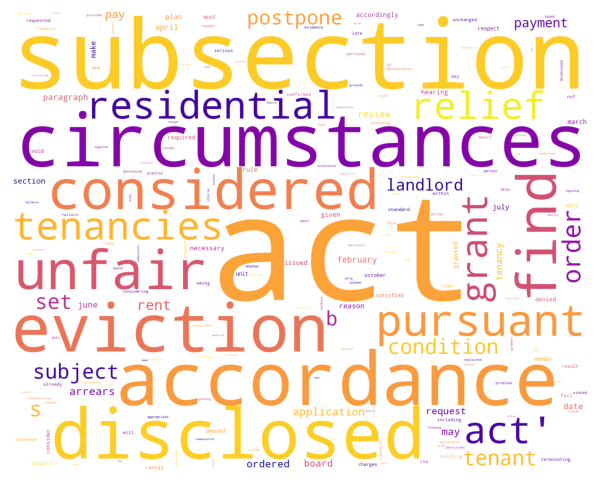

In [91]:
all_outcomes_str = ""
for test_row in gold_df.index:
    test_str = " ".join(gold_df.loc[test_row, 'content'])
    cospan = get_outcome_span(test_str, return_truncated = True)
    if cospan:
        all_outcomes_str += cospan.lower().strip() + " "

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(width = 1500, height = 1200, random_state = 1, background_color = 'white', colormap = 'plasma', collocations = False, stopwords = STOPWORDS).generate(all_outcomes_str)
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud)
plt.axis("off");

# Writing to new df

In [19]:
# gold_df.value_counts('new_case_outcome')
# gold_df_reduced = gold_df.drop(columns = [col for col in gold_df.columns if col not in ["new_case_outcome", "raw_file_name", 'content']])
# # gold_df_reduced['outcome_span'] = gold_df_reduced['content'].apply(get_outcome_span)

# for row in gold_df.index:
#     content = " ".join(gold_df.loc[row, 'content'])
#     outcome_span = get_outcome_span(content)
#     gold_df_reduced.loc[row, 'outcome_span'] = outcome_span
# # 'data/outcome_extraction_testing.csv'
# len(gold_df_reduced['outcome_span'].unique()) # only 265 unique outcomes spans out of 672?

# gold_df_reduced.head()

,raw_file_name,content,new_case_outcome,outcome_span
0,CEL-62600-16.txt,[Arrears Worksheet File Number: CEL-62600-16 T...,No relief,No circumstances were disclosed in accordance ...
1,CEL-62852-16.txt,[Arrears Worksheet File Number: CEL-62852-16 T...,Relief,I have considered all of the disclosed circums...
2,CEL-63024-16.txt,[Arrears Worksheet File Number: CEL-63024-16 T...,Relief,I have considered all of the disclosed circums...
3,CEL-63056-16.txt,[Arrears Worksheet File Number: CEL-63056-16 T...,No relief,I have considered all of the disclosed circums...
4,CEL-63193-16.txt,[Arrears Worksheet File Number: CEL-63193-16 T...,No relief,I have considered all of the disclosed circums...


# Testing on all Cases

In [80]:
# read in all 44k cases here
# all_cases = pd.read_csv("/Users/kmaurinjones/Desktop/School/UBC/UBC_Coursework/capstone/Allard_A_Capstone/large_files/44k_cases_pproc_filenums.csv")
all_cases = read_csv_with_lists("/Users/kmaurinjones/Desktop/School/UBC/UBC_Coursework/capstone/Allard_A_Capstone/large_files/44k_cases_pproc_filenums.csv")
all_cases.head()

,year,raw_file_name,raw_file_text,full_cleaned,metadata,content,language,case_citation,file_number
0,2013,NOL-10723-12.txt,Metadata:\nDate:\t2013-01-08\nFile number:\t\n...,"[Metadata:, Date: 2013-01-08, File number:, NO...","[Date: 2013-01-08, File number:, NOL-10723-12,...","[Order under Section 69, Residential Tenancies...",English,"NOL-10723-12 (Re), 2013 CanLII 5182 (ON LTB)",NOL-10723-12
1,2013,TNL-43964-13.txt,Metadata:\nDate:\t2013-05-02\nFile number:\t\n...,"[Metadata:, Date: 2013-05-02, File number:, TN...","[Date: 2013-05-02, File number:, TNL-43964-13,...",[Order under section 69 Residential Tenancies ...,English,"TNL-43964-13 (Re), 2013 CanLII 36866 (ON LTB)",TNL-43964-13
2,2013,TNL-45470-13.txt,Metadata:\nDate:\t2013-06-17\nFile number:\t\n...,"[Metadata:, Date: 2013-06-17, File number:, TN...","[Date: 2013-06-17, File number:, TNL-45470-13,...",[Order under Section 69 Residential Tenancies ...,English,"TNL-45470-13 (Re), 2013 CanLII 44492 (ON LTB)",TNL-45470-13
3,2013,TEL-33159-13; \n TET-33272-13.txt,Metadata:\nDate:\t2013-02-25\nFile number:\t\n...,"[Metadata:, Date: 2013-02-25, File number:, TE...","[Date: 2013-02-25, File number:, TEL-33159-13;...",[Order under sections 31 and 69 Residential Te...,English,"TEL-33159-13 (Re), 2013 CanLII 50418 (ON LTB)",TEL-33159-13; TET-33272-13
4,2013,TNL-39747-12.txt,Metadata:\nDate:\t2013-02-07\nFile number:\t\n...,"[Metadata:, Date: 2013-02-07, File number:, TN...","[Date: 2013-02-07, File number:, TNL-39747-12,...",[Order under Section 68 Residential Tenancies ...,English,"TNL-39747-12 (Re), 2013 CanLII 10834 (ON LTB)",TNL-39747-12


In [92]:
total_found = 0
not_found = []
oc_lens = []

for row in all_cases.index: # 106 throws indexerror
    # print(row)

    # row = 108
    content_str = " ".join(all_cases.loc[row, 'content'])
    # content_str = " ".join(content_list) # only if the content is a list
    # print(gold_df['new_case_outcome'].tolist()[row])
    
    try:
        
        oc_statement = get_outcome_span(content_str)
        # print(oc_statement)
        if oc_statement:
            total_found += 1
            oc_lens.append(len(oc_statement.split()))
        else:
            not_found.append(row)

    except Exception:
        not_found.append(row) # error analysis

print(total_found / len(all_cases.index))
print(len(all_cases))
print(len(not_found))
print(not_found)
print()
print(max(oc_lens))
print(sum(oc_lens) / len(oc_lens)) # average of 61 words per extracted outcome span
print(sorted(oc_lens)[len(oc_lens) // 2]) # median of 60 words per extracted outcome span

0.9966588859902055
43698
146
[55, 101, 102, 196, 352, 357, 480, 502, 518, 616, 643, 791, 908, 928, 1002, 1010, 1014, 1105, 1210, 1271, 1345, 1383, 1428, 2963, 4760, 5813, 6561, 7015, 7302, 7488, 7734, 7957, 8010, 8132, 8259, 8445, 8698, 8714, 8807, 8913, 9409, 9735, 9775, 10048, 10062, 10104, 10118, 10150, 10372, 10380, 10389, 10414, 10565, 10683, 10777, 10814, 10818, 10853, 10884, 10894, 10955, 11000, 11122, 11177, 11370, 11577, 12806, 14331, 14423, 14472, 14548, 14562, 14695, 14995, 15084, 15292, 15305, 15346, 15469, 15496, 15572, 15588, 15690, 15714, 15779, 16025, 16269, 17547, 17729, 18091, 18444, 18627, 18787, 19031, 19467, 19560, 19981, 19984, 20291, 21274, 21941, 22065, 22580, 22668, 24306, 25532, 25919, 26420, 26456, 26962, 27910, 28101, 28572, 29065, 29123, 29688, 30054, 30135, 31009, 31257, 31300, 31866, 32330, 33326, 33650, 34362, 35307, 36007, 36875, 36972, 37002, 37409, 37670, 37698, 38370, 38903, 40527, 40598, 40669, 40843, 40997, 41146, 41361, 41811, 42131, 42405]

209
5

# Error Analysis -- Longformer next?
- Could probably use Longformer for the cases where the span can't be extracted using the rule-based approach

In [93]:
row = 105
total_len = []
for row in not_found:

    content_str = " ".join(all_cases.loc[row, 'content'])
    
    # metadata = " ".join(all_cases.loc[row, 'metadata'])
    # print((row, re.findall(r'<(.*?)>', metadata)[0])) # url

    # print(len(get_outcome_span(content_str).split()))
    # print(len(content_str.split())) # number of words in the case file
    total_len.append(len(content_str.split()))
    # print(get_outcome_span(content_str))
    # break

print()
print(max(total_len)) # average number of words in a case file that doesn't have an outcome statement
print(sum(total_len) / len(not_found)) # average number of words in a case file that doesn't have an outcome statement
print(sorted(total_len)[len(total_len) // 2]) # median


2878
310.1986301369863
182


In [94]:
total_len.index(max(total_len))
# not_found[66]

69